Try out our kNN bootstrap method on the degree heterogeneous international trade data. 

Will bootstrap the 2020 data, then can compare it to 2021 for the whole, is this the same?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from embedding_functions import *
from experiment_setup import *
from functions_for_bootstrap import *
import numba as nb
from tqdm import tqdm

In [2]:
folder = "/home/uj21900/Documents/CommonCrawlData/InternationalTradeData/"

In [3]:
# Read in the export data from 2016 to 2021
M_2016_2021_list = []
for t in range(2016,2022):
    filename = folder + 'M_export_' + str(t) + '.csv'
    df = pd.read_csv(filename)
    M = np.array(df)
    M_2016_2021_list.append(M)

In [4]:
# read in the export indices names
total = pd.read_csv(folder+'exportMatricesIndices.csv', header=None)

total = list(total[0])

In [5]:
M_2016_2021_list
n = M_2016_2021_list[0].shape[0]
T = len(M_2016_2021_list)
print(n,T)

144 6


In [6]:
# put A_list into a 3D array
As = np.zeros((T,n,n))
for t in range(T):
    As[t,:,:] = M_2016_2021_list[t]

In [7]:
# read in inflation rate data, at a world level
# https://data.worldbank.org/indicator/FP.CPI.TOTL.ZG
inflationrates = pd.read_csv(folder+'worldbank_inflationRateData.csv')

worldIR = inflationrates[inflationrates['Country Name']=='World']

In [8]:
worldIR = worldIR.iloc[:, -(T+1):]
# remove the last column as it's for 2022
worldIR = worldIR.iloc[:, :-1]
worldIR = worldIR.reset_index(drop=True)
worldIR

,2016,2017,2018,2019,2020,2021
0,1.550016,2.19201,2.438737,2.206073,1.928955,3.475403


In [9]:
# put the values in a list
worldIRlist = list(worldIR.iloc[0,:])

# want it to be the proportion, i.e, 3% = 1.03
worldIRlist_prop = [x/100 + 1 for x in worldIRlist]

In [10]:
IRadj_As = np.zeros((T,n,n))

from functools import reduce

for t in range(T):
    mat = As[t]
    cumulative_inflation = worldIRlist_prop[(t+1):T]
    # multiply all items in a list
    if len(cumulative_inflation) > 0:
        cumulative_inflation = reduce(lambda x, y: x*y, cumulative_inflation)
    else:
        cumulative_inflation = 1
    mat = mat*cumulative_inflation
    IRadj_As[t] = mat

In [11]:
# LOOK AT 2020
A_2020 = IRadj_As[4]
d=2
ya = UASE([A_2020], d)
# plot_embedding(ya, n, 1, np.ones(n))

In [12]:
yadf = pd.DataFrame(ya)

# rename the columns - this is called a list comprehension
yadf.columns = ["Dimension_{}".format(i+1) for i in range(yadf.shape[1])] 
# give each node a number
yadf['node_number'] = list(range(n))
yadf['country'] = total

In [13]:
fig = px.scatter(yadf, x="Dimension_1", y="Dimension_2",
                hover_data=["country", "node_number"],
                color_continuous_scale = 'Bluered', title=f"The A matrix for 2020 embedded, with UASE d={d}")

fig.show()

In [14]:
pvalues, A_bootstraps = test_bootstrap(A_2020, d=2, dc=False)

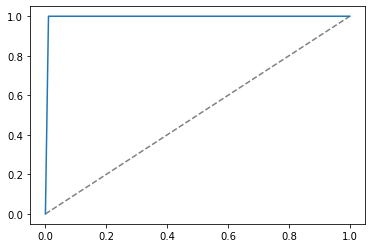

1.0

In [18]:
plot_power(pvalues, plot=True)

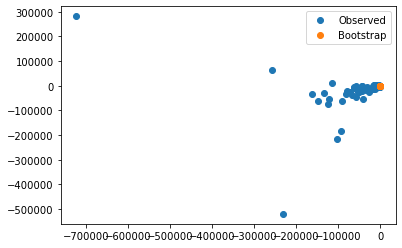

In [28]:
yhat_plot = UASE([A_2020, A_bootstraps[0]], d=2, flat=False)

plt.plot(yhat_plot[0, :, 0], yhat_plot[0, :, 1], 'o', label="Observed", alpha=1)
plt.plot(yhat_plot[1, :, 0], yhat_plot[1, :, 1], 'o', label="Bootstrap", alpha=1)

plt.legend()

In [22]:
yhat_plot.shape

(2, 144, 2)

Try some, divide by degree, then multiply back by it later

Perhaps symmetrise first will be more helpful

In [58]:
# symmetrise the matrices

symm_IRadj_As = np.zeros((T,n,n))

for t in range(T):
    mat = IRadj_As[t]
    matT = np.transpose(mat)
    symm_mat = (mat + matT)/2
    symm_IRadj_As[t] = symm_mat

In [59]:
# LOOK AT 2020
A_symm_2020 = symm_IRadj_As[4]

deg_mat = np.diag(np.sum(A_symm_2020, axis=1))

A_symm_2020_DC = np.linalg.inv(np.sqrt(deg_mat)) @ A_symm_2020 @ np.linalg.inv(np.sqrt(deg_mat))

In [60]:
p_values_DC, A_bootstraps_DC = test_bootstrap(A_symm_2020_DC, d=2, dc=False)

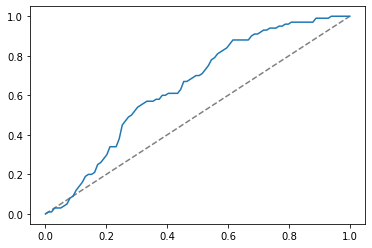

0.03

In [62]:
plot_power(p_values_DC, plot=True)

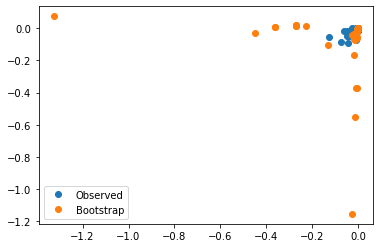

In [63]:
yhat_plot = UASE([A_symm_2020_DC, A_bootstraps_DC[0]], d=2, flat=False)

plt.plot(yhat_plot[0, :, 0], yhat_plot[0, :, 1], 'o', label="Observed", alpha=1)
plt.plot(yhat_plot[1, :, 0], yhat_plot[1, :, 1], 'o', label="Bootstrap", alpha=1)

plt.legend()


In [51]:
# make A_2020_symm_binary  where this is a 1 if A_2020_symm > 0, and 0 otherwise
A_symm_2020_binary = np.zeros((n,n))
A_symm_2020_binary[A_symm_2020 > 0] = 1

p_values_binary, A_bootstraps_binary = test_bootstrap(A_symm_2020_binary, d=2, dc=False)

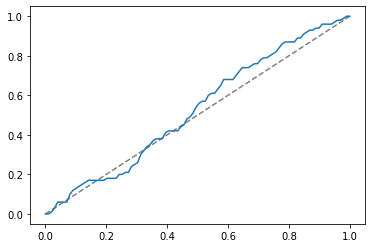

0.06

In [55]:
plot_power(p_values_binary, plot=True)

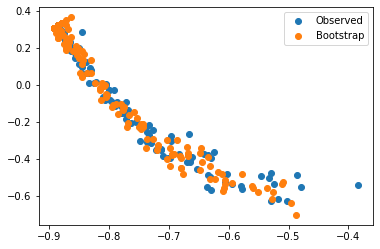

In [110]:
yhat_plot = UASE([A_symm_2020_binary, A_bootstraps_binary[1]], d=2, flat=False)

plt.plot(yhat_plot[0, :, 0], yhat_plot[0, :, 1], 'o', label="Observed", alpha=1)
plt.plot(yhat_plot[1, :, 0], yhat_plot[1, :, 1], 'o', label="Bootstrap", alpha=1)

plt.legend()

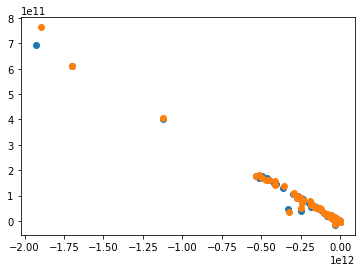

In [68]:
yhat_transform = deg_mat @ yhat_plot

plt.plot(yhat_transform[0, :, 0], yhat_transform[0, :, 1], 'o', label="Observed transformed", alpha=1)
plt.plot(yhat_transform[1, :, 0], yhat_transform[1, :, 1], 'o', label="Bootstrap tranformed", alpha=1)

In [75]:
yhat_transform_flat = np.row_stack(yhat_transform)
yhat_transform_flat.shape

(288, 2)

In [78]:
yadf_transformed = pd.DataFrame(yhat_transform_flat)

# rename the columns - this is called a list comprehension
yadf_transformed.columns = ["Dimension_{}".format(i+1) for i in range(yadf_transformed.shape[1])] 
# give each node a number
yadf_transformed['node_number'] = list(range(n))*2
yadf_transformed['country'] = total*2
yadf_transformed['type'] = ['Observed']*n + ['Bootstrap']*n

In [79]:
fig = px.scatter(yadf_transformed, x="Dimension_1", y="Dimension_2",
                hover_data=["country", "node_number"],
                color='type', 
                color_continuous_scale = 'Bluered', title=f"The A matrix for 2020 embedded, with UASE d={d}")

fig.show()

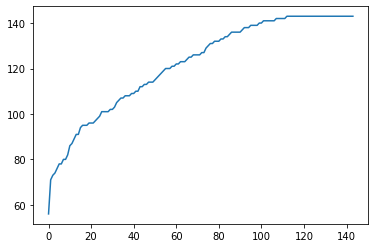

In [123]:
# plot the sorted degree of 2020 binary
deg = np.sum(A_symm_2020_binary, axis=0)
deg_sort = np.sort(deg)

plt.plot(deg_sort)

No handles with labels found to put in legend.


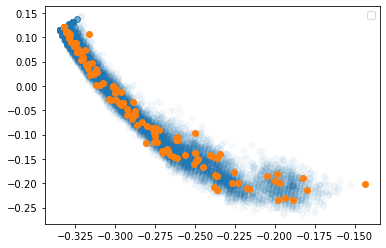

In [120]:
yhat_plot = UASE(A_obs_and_bootstraps, d=2, flat=False)

# plt.plot(yhat_plot[1:, 14, 0], yhat_plot[1: , 14, 1], 'o', label="Bootstrap", alpha=1)
# plt.plot(yhat_plot[0, 14, 0], yhat_plot[0, 14, 1], 'o', label="Observed", alpha=1)

# plt.plot(yhat_plot[1:, 86, 0], yhat_plot[1: , 86, 1], 'o', label="Bootstrap", alpha=1)
# plt.plot(yhat_plot[0, 86, 0], yhat_plot[0, 86, 1], 'o', label="Observed", alpha=1)

plt.scatter(yhat_plot[1:, :, 0], yhat_plot[1:, :, 1], alpha=0.03)

plt.scatter(yhat_plot[0, :, 0], yhat_plot[0, :, 1])
# plt.scatter(yhat_plot[1, :, 0], yhat_plot[1, :, 1])
# plt.scatter(yhat_plot[2, :, 0], yhat_plot[2, :, 1])


plt.legend()

# the lone dot, we think is overlapped the countries that all export to all the other places, 
# so by kNN they have zero resample variance in the binary setting

<AxesSubplot:>

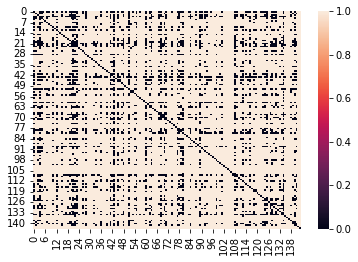

In [124]:
sns.heatmap(A_symm_2020_binary)

In [ ]:
# we need to compare yadf_transformed['bootstrap'] and yadf from the true A